训练集标注可视化

In [126]:
%config InlineBackend.figure_format = 'retina'

In [127]:
import cv2
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
from glob import glob
import json
import numpy as np
from pathlib import Path
from tqdm import tqdm



# 按行生成彩色标注框
idx2color = []
for i in range(3):
    for j in range(3):
        for k in range(3):
            idx2color.append((i*100, j*100, k*100))
idx2color.append((255, 0, 0))
idx2color = np.array(idx2color)


def table_visualize(img_name, src_img, table, key='row', only_last=False):
    last_img = src_img.copy()
    for idx, row in enumerate(table[key]):
        color = idx2color[idx % len(idx2color)]
        pts = np.array(row, dtype=np.int32)
        if not only_last:
            temp_img = src_img.copy()
            cv2.polylines(temp_img, [pts], True, color.tolist(), 1)
        cv2.polylines(last_img, [pts], True, color.tolist(), 1)
        
        cx, cy = pts.mean(axis=0)
        if not only_last:
            cv2.putText(temp_img, str(idx), (int(cx), int(cy)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color.tolist(), 1)
            temp_img = cv2.cvtColor(temp_img, cv2.COLOR_BGR2RGB)
            plt.title(f"{img_name}: {key}")
            plt.imshow(temp_img)
            plt.show()
        cv2.putText(last_img, str(idx), (int(cx), int(cy)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color.tolist(), 1)
        last_img = cv2.cvtColor(last_img, cv2.COLOR_BGR2RGB)
    plt.title(f"{img_name}: {key}")
    plt.imshow(last_img)
    plt.show()

def label_visualize(img_name, src_img, label):
    for cell in label['cells']:
        start_row_idx = cell['row_start_idx']
        end_row_idx   = cell['row_end_idx']
        start_col_idx = cell['col_start_idx']
        end_col_idx   = cell['col_end_idx']
        color = idx2color[start_row_idx % len(idx2color)]
        x0, y0, x1, y1 = cell['bbox']

        pts = np.array(cell['segmentation'], dtype=np.int32)
        cv2.rectangle(src_img, (int(x0), int(y0)), (int(x1), int(y1)), color.tolist(), 1)

        theight = cv2.getTextSize(str(start_row_idx), cv2.FONT_HERSHEY_SIMPLEX, 1, 2)[0][1]
        show_text = f"{start_row_idx}" if start_row_idx == end_row_idx else f"{start_row_idx}-{end_row_idx}"
        show_text += f",{start_col_idx}" if start_col_idx == end_col_idx else f" {start_col_idx}-{end_col_idx}"

        cv2.putText(src_img, show_text, (int(x0), int(y0)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color.tolist(), 1)
        # transcript = cell['transcript']
        # cv2.putText(src_img, transcript, (int(x0), int(y0)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color.tolist(), 1)
        plt.title(img_name)
        plt.imshow(src_img)
    plt.show()

def rotate_label_visualize(img_name, src_img, label):
    h, w = src_img.shape[:2]
    center = (w//2, h//2)
    M = cv2.getRotationMatrix2D(center, -1, 1.0)
    src_img = cv2.warpAffine(src_img, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    # src_img = cv2.warpAffine(src_img, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_CONSTANT, borderValue=(0,0,0))

    for cell in label['cells']:
        start_row_idx = cell['row_start_idx']
        end_row_idx   = cell['row_end_idx']
        start_col_idx = cell['col_start_idx']
        end_col_idx   = cell['col_end_idx']
        color = idx2color[start_row_idx % len(idx2color)]
        x0, y0, x1, y1 = cell['bbox']
        print(1, type(cv2.transform(np.array([[[x0, y0], [x1, y1]]]), M)))
        print(2, type(cv2.transform(np.array([[[x0, y0], [x1, y1]]]), M).squeeze()))
        [x0, y0], [x1, y1] = cv2.transform(np.array([[[x0, y0], [x1, y1]]]), M).squeeze().astype(np.int32)

        pts = np.array(cell['segmentation'], dtype=np.int32)
        cv2.rectangle(src_img, (int(x0), int(y0)), (int(x1), int(y1)), color.tolist(), 1)

        theight = cv2.getTextSize(str(start_row_idx), cv2.FONT_HERSHEY_SIMPLEX, 1, 2)[0][1]
        show_text = f"{start_row_idx}" if start_row_idx == end_row_idx else f"{start_row_idx}-{end_row_idx}"
        show_text += f",{start_col_idx}" if start_col_idx == end_col_idx else f" {start_col_idx}-{end_col_idx}"

        cv2.putText(src_img, show_text, (int(x0), int(y0)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color.tolist(), 1)
        plt.title(img_name)
        plt.imshow(src_img)
    plt.show()





In [128]:
import copy
from Polygon import Polygon



def segmentation_to_bbox(segmentation):
    x1 = min([min([pt[0] for pt in contour]) for contour in segmentation])
    y1 = min([min([pt[1] for pt in contour]) for contour in segmentation])
    x2 = max([max([pt[0] for pt in contour]) for contour in segmentation])
    y2 = max([max([pt[1] for pt in contour]) for contour in segmentation])
    return [x1, y1, x2, y2]


def crop_row_col(image, table, crop_mode=None, crop_num=0, crop_range=(0, 0.8)):
    image = copy.deepcopy(image)
    all_modes = ['row_up', 'row_down', 'col_left', 'col_right']
    if crop_mode == None:
        crop_mode = np.random.choice(all_modes)
    assert crop_mode in all_modes

    num_rows = len(table['row'])
    num_cols = len(table['col'])
    if num_rows < 2 or num_cols < 2:
        return False

    if crop_num == 0:
        if crop_mode in ['row_up', 'row_down']:
            low = max(1, int(num_rows * crop_range[0]))
            high = min(num_rows - 1, int(num_rows * crop_range[1]))
        else:
            low = max(1, int(num_cols * crop_range[0]))
            high = min(num_cols - 1, int(num_cols * crop_range[1]))
        if low >= high:
            low, high = high, low
        crop_num = np.random.randint(low, high)

    rows, cols = sort_sementations(table['row'], table['col'])

    if crop_mode == 'row_up':
        crop_segs = rows[:crop_num]
    elif crop_mode == 'row_down':
        crop_segs = rows[-crop_num:]
    elif crop_mode == 'col_left':
        crop_segs = cols[:crop_num]
    else:
        crop_segs = cols[-crop_num:]

    crop_bbox = segmentation_to_bbox(crop_segs)
    # cv2.rectangle(image, (crop_bbox[0], crop_bbox[1]), (crop_bbox[2], crop_bbox[3]), color=(0,0,255), thickness=2)
    # display(Image.fromarray(image))
    
    x1, y1, x2, y2 = np.array(crop_bbox).astype(np.int32).tolist()

    if crop_mode == 'row_up':
        axis = y2
        crop_image = image[axis:]
    elif crop_mode == 'row_down':
        axis = y1
        crop_image = image[:axis]
    elif crop_mode == 'col_left':
        axis = x2
        crop_image = image[:, axis:]
    elif crop_mode == 'col_right':
        axis = x1
        crop_image = image[:, :axis]

    print(crop_bbox)
    print(crop_image.shape)

    print(len(table['row']))
    print(len(table['col']))
    new_rows = update_axis(table['row'],  axis, crop_mode, crop_image.shape, key='row')
    new_cols = update_axis(table['col'],  axis, crop_mode, crop_image.shape, key='col')
    new_line = update_axis(table['line'], axis, crop_mode, crop_image.shape, key='line')
    new_cell = update_axis(table['cell'], axis, crop_mode, crop_image.shape, key='cell')

    print(len(new_rows))
    print(len(new_cols))
    if len(new_line) == 0:
        return False, False

    new_table = dict(row=new_rows,
                     col=new_cols,
                     line=new_line,
                     cell=new_cell,
                     is_wireless=table['is_wireless'])
    return new_table, crop_image


def update_axis(segmentations, axis, mode, img_shape, key):
    ## row
    new_segmentations = []
    for segmentation in segmentations:
        polygon_pre = Polygon(segmentation)
        area_pre = polygon_pre.area()
        segmentation = np.array(segmentation)
        if mode == 'row_up':
            segmentation[:, 1] -= axis ###
        elif mode == 'col_left':
            segmentation[:, 0] -= axis ###
        segmentation[:, 0] = np.clip(segmentation[:, 0], 0, img_shape[1])
        segmentation[:, 1] = np.clip(segmentation[:, 1], 0, img_shape[0])
        polygon = Polygon(segmentation)
        # if polygon.area() > 0.1 * area_pre:
        #     new_segmentations.append(segmentation.tolist())
        if key =='line':
            if polygon.area() > 0.6 * area_pre:
                new_segmentations.append(segmentation.tolist())
        else:
            new_segmentations.append(segmentation.tolist())

    return new_segmentations


def sort_sementations(rows, cols):
    # sort rows from top to down
    row_locs = []
    for row_seg in rows:
        points_ = np.vstack(itm for itm in row_seg)
        row_loc_ = np.mean(points_, axis=0)[1]
        row_locs.append(row_loc_)
    row_index = np.argsort(row_locs)
    rows = [rows[idx_] for idx_ in row_index]

    # sort cols from left to right
    col_locs = []
    for col_seg in cols:
        points_ = np.vstack(itm for itm in col_seg)
        col_loc_ = np.mean(points_, axis=0)[0]
        col_locs.append(col_loc_)
    col_index = np.argsort(col_locs)
    cols = [cols[idx_] for idx_ in col_index]

    return rows, cols

/tmp/ipykernel_1473386/3330180691.py:119: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  points_ = np.vstack(itm for itm in row_seg)
/tmp/ipykernel_1473386/3330180691.py:128: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  points_ = np.vstack(itm for itm in col_seg)


[229.33812615955472, 12.079777365491651, 368.2555658627087, 469.1572356215213]
(480, 229, 3)
39
7
39
7


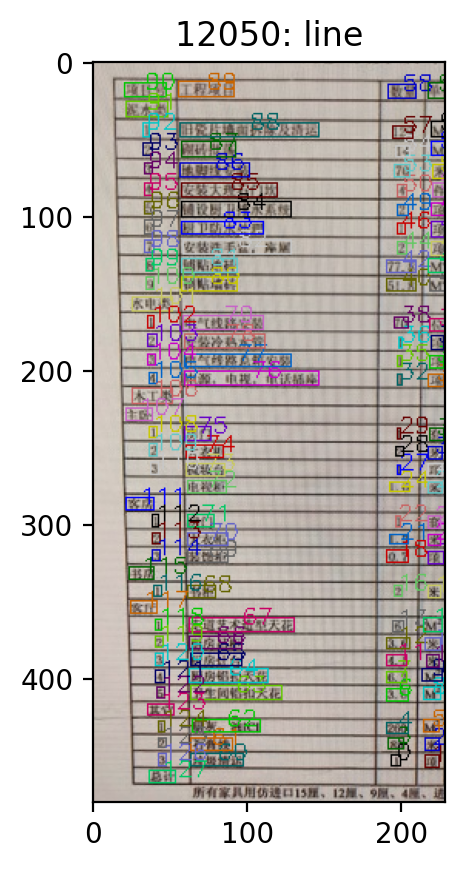

In [129]:
import utils.table2label as table2label
import random
'''
可视化单一图像
'''
img_id = '12050'
jpg_path  = f"/media/ubuntu/Date12/TableStruct/new_data/train_jpg480max/{img_id}.jpg"
json_path = f"/media/ubuntu/Date12/TableStruct/new_data/train_jpg480max/{img_id}.json"

img_array = cv2.imread(jpg_path)
rc_label = json.load(open(json_path, 'r'))
# rc_label['is_wireless'] = True

rc_label, img_array = crop_row_col(img_array, rc_label)

table_visualize(img_id, img_array, rc_label, key='line', only_last=True)
